<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/other_optimezers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
!pip install --upgrade torch


## Imports

In [140]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
NUM_EPOCHS = 150
BATCH_SIZE = 64
NUM_WORKER_LIST = [1, 2, 4, 8]
LOCAL_STEPS = [1, 4, 8, 16, 32, 64]
LR = 0.01
WD = 0.001
MOMENTUM = 0.9
ALPHA = 1.0
BETA = 0.4

## Model

In [142]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

In [143]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='/content/drive/MyDrive/Early2checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer=None):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_loss_min': val_loss
        }
        torch.save(checkpoint, self.path)
        self.val_loss_min = val_loss



## Function to get train, test and val dataset

In [144]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=2)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [145]:
def get_dataset(batch_size, verbose=True):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    if verbose:
      print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    if verbose:
      for i, (inputs, labels) in enumerate(train_loader):
          print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
          if i == 10:
              break
      print(f"Data loading for 10 batches completed.")
      print(f"Training dataset size: {len(train_dataset)}")
      print(f"Validation dataset size: {len(val_dataset)}")
      print(f"Test dataset size: {len(test_dataset)}")


    print("Data load correctly...")

    return train_loader, val_loader, test_loader

In [146]:
class CheckpointSaver:

  def __init__(self, path, additional_info, k, j, hyperparams, epochs):
    self.timestamp = time.strftime("%Y%m%d-%H%M%S")
    self.path = f"{path}/K={k}_J={j}_Comparison_{self.timestamp}"
    self.additional_info = additional_info
    self.k = k
    self.j = j
    self.hyperparams = hyperparams
    self.epochs = epochs

  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'global_train_acc': os.path.join(self.path, f'localSGD_train_accuracy_{self.timestamp}_{str(self.additional_info)}.txt'),
        'val_acc': os.path.join(self.path, f'localSGD_val_accuracy_{self.timestamp}_{str(batch_size)}.txt'),
        'global_train_loss': os.path.join(self.path, f'localSGD_train_loss_{self.timestamp}_{str(self.additional_info)}.txt'),
        'val_loss': os.path.join(self.path, f'localSGD_val_loss_{self.timestamp}_{str(self.additional_info)}.txt')
    }

    with open(os.path.join(self.path, f'localSGD_experiment_config_{self.timestamp}_{str(self.additional_info)}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"Optimizer: localSGD\n")
        f.write(f"K = {self.k}; J = {self.j}\n")
        f.write(f"Hyperparameters: {str(self.hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")
        f.write(f"Timestamp: {self.timestamp}\n")


  def save_checkpoint(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss):
      try:
          with open(self.metrics_files['global_train_acc'], 'a') as f:
              f.write(f"{epoch},{global_train_accuracy * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['global_train_loss'], 'a') as f:
              f.write(f"{epoch},{global_train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")



# SlowMo Framework

Start loading data with batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 2.04 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torc

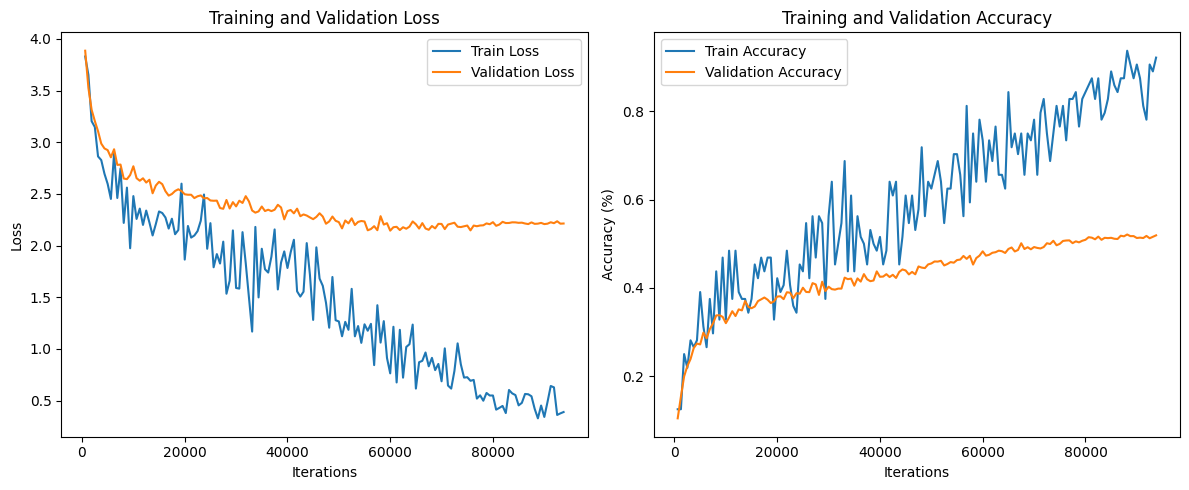

Running SlowMo with 1 workers and 4 local steps
Epoch 1: Updating Global LR
Epoch 1/150 | Train Loss: 3.7057, Train Acc: 10.55% | Val Loss: 3.9968, Val Acc: 8.38%
Iteration 156: Global LR222 = 0.009999
Iteration 156: Local Workerbbb 0 LR = 0.009999
[Epoch 1] After validation:
Allocated Memory: 222.54 MB
Reserved Memory: 266.00 MB
Epoch 2: Updating Global LR
Epoch 2/150 | Train Loss: 3.4809, Train Acc: 11.33% | Val Loss: 3.6933, Val Acc: 13.05%
Iteration 312: Global LR222 = 0.009996
Iteration 312: Local Workerbbb 0 LR = 0.009996
[Epoch 2] After validation:
Allocated Memory: 222.06 MB
Reserved Memory: 266.00 MB
Epoch 3: Updating Global LR
Epoch 3/150 | Train Loss: 3.4141, Train Acc: 19.14% | Val Loss: 3.4383, Val Acc: 17.23%
Iteration 468: Global LR222 = 0.009990
Iteration 468: Local Workerbbb 0 LR = 0.009990
[Epoch 3] After validation:
Allocated Memory: 222.02 MB
Reserved Memory: 266.00 MB
Epoch 4: Updating Global LR
Epoch 4/150 | Train Loss: 3.3100, Train Acc: 16.80% | Val Loss: 3.2652

KeyboardInterrupt: 

In [147]:
def vector_to_parameters(vector, parameters):
    pointer = 0
    for param in parameters:
        # The length of the current parameter as a flat vector
        num_param = param.numel()

        # Reshape the vector segment into the shape of the current parameter
        param.data = vector[pointer:pointer + num_param].view_as(param.data)

        # Move pointer ahead
        pointer += num_param

def split_cifar100(dataset, num_workers):
    indices = np.random.permutation(len(dataset))
    splits = np.array_split(indices, num_workers)
    return [torch.utils.data.Subset(dataset, split) for split in splits]

def slowmo_alg(train_loader, val_loader, test_loader, device, num_workers, local_steps, num_epochs, batch_size, hyperparams, slowmo_params, verbose=True):
    dataset_size = len(train_loader.dataset)
    datasets = split_cifar100(train_loader.dataset, num_workers)
    workers = [
        DataLoader(datasets[i], batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        for i in range(num_workers)
    ]

    # Calculate number of iterations
    total_iterations = (num_epochs * (dataset_size // batch_size)) // (num_workers * local_steps)
    iterations_per_epoch = total_iterations // num_epochs

    computation_time = 0.0
    communication_time = 0.0

    # Create global and local models and optimizers
    global_model = LeNet5().to(device)
    global_optimizer = optim.SGD(
        global_model.parameters(),
        lr=hyperparams['lr'],
        weight_decay=hyperparams['weight_decay'],
        momentum=hyperparams['momentum']
    )

    local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]
    local_optimizers = [
        optim.SGD(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            momentum=hyperparams['momentum']
        ) for model in local_models
    ]

    with torch.no_grad():
        averaged_params = torch.nn.utils.parameters_to_vector(global_model.parameters()).clone()
        slow_momentum = torch.zeros_like(averaged_params, device=device)

    scheduler = CosineAnnealingLR(global_optimizer, T_max=total_iterations)
    # schedulers = [CosineAnnealingLR(opt, T_max=num_epochs) for opt in local_optimizers]

    criterion = nn.CrossEntropyLoss()

    cs = CheckpointSaver(
        path=f"/content/drive/My Drive/Colab Notebooks/Traning_summary/",
        additional_info=f"K={num_workers}_J={local_steps}",
        k=num_workers,
        j=local_steps,
        hyperparams=hyperparams,
        epochs=num_epochs
    )

    cs.create_files()

    best_model = None
    best_val_loss = float('inf')

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    computation_times = []
    communication_times = []

    global_lr = global_optimizer.param_groups[0]['lr']
    for local_optimizer in local_optimizers:
        for param_group in local_optimizer.param_groups:
            param_group['lr'] = global_lr

    for iteration in range(1, total_iterations + 1):
        start_computation = time.time()
        with torch.no_grad():
            initial_params = torch.nn.utils.parameters_to_vector(global_model.parameters()).clone()

        # print(f"Iteration {iteration}: Global LR111 = {global_lr:.6f}")

        worker_iters = [iter(workers[i]) for i in range(num_workers)]
        worker_train_losses = []
        worker_train_accuracies = []

        for worker_id in range(num_workers):
            local_lrs = [
                optimizer.param_groups[0]['lr'] for optimizer in local_optimizers
            ]
            # for worker_id, lr in enumerate(local_lrs):
            #     print(f"Iteration {iteration}: Local Workeraaaa {worker_id} LR = {lr:.6f}")
            with torch.no_grad():
                vector_to_parameters(
                    torch.nn.utils.parameters_to_vector(global_model.parameters()),
                    local_models[worker_id].parameters()
                )

            worker_loss, correct, total = 0.0, 0, 0
            for _ in range(local_steps):
                try:
                    inputs, labels = next(worker_iters[worker_id])
                except StopIteration:
                    worker_iters[worker_id] = iter(workers[worker_id])
                    inputs, labels = next(worker_iters[worker_id])

                inputs, labels = inputs.to(device), labels.to(device)
                local_optimizers[worker_id].zero_grad()
                outputs = local_models[worker_id](inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                local_optimizers[worker_id].step()

                worker_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

            worker_loss /= local_steps
            worker_accuracy = correct / total
            worker_train_losses.append(worker_loss)
            worker_train_accuracies.append(worker_accuracy)

        torch.cuda.empty_cache()

        computation_time += time.time() - start_computation
        computation_times.append(computation_time)
        start_communication = time.time()

        # Average params for each local worker
        averaged_params = torch.zeros_like(averaged_params)
        for local_model in local_models:
            averaged_params += torch.nn.utils.parameters_to_vector(local_model.parameters()).to(device)
        averaged_params.div_(num_workers)
        averaged_params = averaged_params.to(device)

        gamma = hyperparams['lr']
        with torch.no_grad():
            slow_momentum = slow_momentum * slowmo_params['beta'] + (1 / gamma) * (initial_params - averaged_params)
            new_params = initial_params - slowmo_params['alpha'] * gamma * slow_momentum
            torch.nn.utils.vector_to_parameters(new_params, global_model.parameters())

        communication_time += time.time() - start_communication
        communication_times.append(communication_time)
        torch.cuda.empty_cache()

        # Metrics for training
        global_train_loss = sum(worker_train_losses) / num_workers
        global_train_accuracy = sum(worker_train_accuracies) / num_workers

        # At each epoch
        if iteration % iterations_per_epoch == 0 or iteration == total_iterations:
            adjusted_epoch = iteration // iterations_per_epoch
            train_losses.append(global_train_loss)
            train_accuracies.append(global_train_accuracy)

            val_acc, val_loss = val_model(global_model, val_loader, criterion, device)

            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            # Save the best model based on validation accuracy
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(global_model.state_dict())
            # Update schedulers
            print(f"Epoch {iteration // iterations_per_epoch}: Updating Global LR")

            # for scheduler in schedulers:
            #     scheduler.step()

            torch.cuda.empty_cache()

            cs.save_checkpoint(adjusted_epoch, global_train_accuracy, val_acc, global_train_loss, val_loss)

            print(f"Epoch {int(adjusted_epoch)}/{num_epochs} | Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_accuracy * 100:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")
            print(f"Iteration {iteration}: Global LR222 = {global_lr:.6f}")
            for worker_id, lr in enumerate(local_lrs):
              print(f"Iteration {iteration}: Local Workerbbb {worker_id} LR = {lr:.6f}")
            if verbose:
                print(f"[Epoch {adjusted_epoch}] After validation:")
                print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
                print(f"Reserved Memory: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

            del worker_train_losses, worker_train_accuracies
            torch.cuda.empty_cache()
        scheduler.step()
        global_lr = global_optimizer.param_groups[0]['lr']
        for local_optimizer in local_optimizers:
            for param_group in local_optimizer.param_groups:
                param_group['lr'] = global_lr
        # print(f"Iteration {iteration}: Global LR222 = {global_lr:.6f}")
        # for worker_id, lr in enumerate(local_lrs):
        #     print(f"Iteration {iteration}: Local Workerbbb {worker_id} LR = {lr:.6f}")

    if best_model is not None:
      global_model.load_state_dict(best_model)
      global_model.eval()
    test_acc = test_model(global_model, test_loader, device)
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, iterations_per_epoch, total_iterations, computation_times, communication_times


def val_model(global_model, val_loader, criterion, device):
    global_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_acc, val_loss

def test_model(global_model, test_loader, device):
    global_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc * 100:.2f}")


# Visualization function
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations):
    # Dynamic calculation record points
    recorded_iterations = len(train_losses)
    iterations = range(iterations_per_epoch, iterations_per_epoch * recorded_iterations + 1, iterations_per_epoch)

    # Ensure data length is consistent
    assert len(train_losses) == len(iterations), f"Train losses and iterations mismatch: {len(train_losses)} vs {len(iterations)}"
    assert len(val_losses) == len(iterations), f"Validation losses and iterations mismatch: {len(val_losses)} vs {len(iterations)}"

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(iterations, train_losses, label="Train Loss")
    plt.plot(iterations, val_losses, label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iterations, train_accuracies, label="Train Accuracy")
    plt.plot(iterations, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epochs = NUM_EPOCHS
    batch_size = BATCH_SIZE
    num_workers_list = NUM_WORKER_LIST
    local_steps_list = LOCAL_STEPS
    hyperparams = {
        'lr': LR,
        'weight_decay': WD,
        'momentum': MOMENTUM,
    }

    slowmo_params = {
        'alpha': ALPHA,
        'beta': BETA
    }

    train_loader, val_loader, test_loader = get_dataset(batch_size)

    for num_workers in num_workers_list:
        for local_steps in local_steps_list:
            print(f"Running SlowMo with {num_workers} workers and {local_steps} local steps")
            train_losses, val_losses, train_accuracies, val_accuracies, test_acc, iterations_per_epoch, total_iterations, computation_times, communication_times = slowmo_alg(
                train_loader=train_loader,
                val_loader=val_loader,
                test_loader=test_loader,
                device=device,
                num_workers=num_workers,
                local_steps=local_steps,
                num_epochs=num_epochs,
                batch_size=batch_size,
                hyperparams=hyperparams,
                slowmo_params=slowmo_params
            )

            print(computation_times, communication_times)

            plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations)
